In [4]:
from __future__ import division
from __future__ import print_function
import numpy as np
import scipy.sparse as ssp
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

In [5]:
class FiberNetwork:
    def __init__(self,Nx,Ny):
        self.Nx = Nx
        self.Ny = Ny
        self.N = Nx*Ny
        self.nrows = self.N - 2*self.Nx
        self.adjmat = ssp.lil_matrix((self.N,self.N), dtype=np.int32)
        self.V = np.zeros(self.N, dtype=np.float64)
        self.V[:Nx] = 1 
    def adj_todense(self):
        return self.adjmat.todense()
    def lap_todense(self):
        return self.lapmat.todense()
    def get_east_neighbour(self,node):
        return (node//self.Nx)*self.Nx + (node+1)%self.Nx
    def get_south_neighbour(self,node):
        return (node+self.Nx)%self.N
    def add_link(self,node1,node2):
        self.adjmat[node1,node2] = 1
        self.adjmat[node2,node1] = 1
    def build_fiber_network_w_bus(self):
        for node in range(self.Nx, self.N-self.Nx):
            self.add_link(node,self.get_east_neighbour(node))
        for node in range(self.N-self.Nx):
            self.add_link(node,self.get_south_neighbour(node))
    def get_neighbors(self,node):
        return self.adjmat.rows[node]
    def lapmat(self):
        lapmat = ssp.lil_matrix((self.nrows,self.nrows), dtype=np.float64)
        for node in range(self.Nx, self.N-self.Nx):
            i = node - self.Nx
            neighbors = self.get_neighbors(node)
            degree = len(neighbors)
            lapmat[i,i] = degree
            for nn in neighbors:
                if(nn>=self.Nx and nn<self.N-self.Nx):
                    j = nn - self.Nx
                    lapmat[i,j] = -1 
        return lapmat.tocsr()
    def rhs(self):
        rhs = np.zeros(self.nrows, dtype=np.float64)
        for node in range(self.Nx, 2*self.Nx):
            neighbors = self.get_neighbors(node)
            if node-self.Nx in neighbors:
                rhs[node-self.Nx] = self.V[node-self.Nx]
        return rhs
    def update_potentials(self,x):
        self.V[self.Nx:self.N-self.Nx] = x
    def remove_fiber_between_nodes(self,node1,node2):
        self.adjmat[node1,node2] = 0
        self.adjmat[node2,node1] = 0
    def plot_potentials(self):
        side = self.Nx
        matrixV = self.V.reshape((side,side))
        plt.matshow(matrixV)
    def plot_network(self):
        f, ax = plt.subplots()
        ax.set_aspect('equal')
        elements = self.adjmat.nonzero()
        for i,j in zip(elements[0],elements[1]):
            if i<j:
                xi, xj = i%self.Nx, j%self.Nx
                yi, yj = i//self.Nx, j//self.Nx
                if j-i==self.Nx-1:
                    xi = xj+1
                ax.plot([xi,xj],[yi,yj],'k-')
    def plot_currents(self):
        f, ax = plt.subplots()
        ax.set_aspect('equal')
        elements = self.adjmat.nonzero()
        for i,j in zip(elements[0],elements[1]):
            if i<j:
                xi, xj = i%self.Nx, j%self.Nx
                yi, yj = i//self.Nx, j//self.Nx
                current = np.abs(self.V[i]-self.V[j])
                if j-i==self.Nx-1:
                    xi = xj+1
                ax.plot([xi,xj],[yi,yj],'k-',lw=20*current)
    def hor_current(self,i):
        hor_current = []
        for j in range((i//self.Nx+1)*self.Nx - i-1):
            print(i+j+1)
            hor_current.append(np.abs(self.V[i+j]-self.V[i+j+1]))
        return hor_current

193
194
195
196
197
198
199
[0.05819824788614636, 0.01573200592443269, 0.005177364271676033, 0.0021004413305583114, 0.0010041085274388184, 0.0005201346880744362, 0.00025661551570665964]


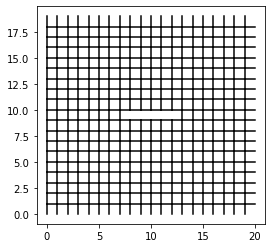

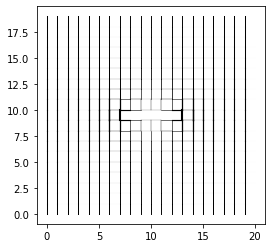

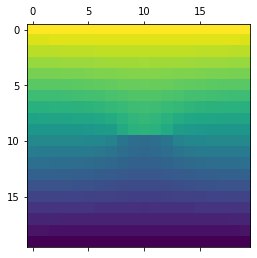

In [3]:
net = FiberNetwork(20,20)
net.build_fiber_network_w_bus()

x = spsolve(net.lapmat(), net.rhs())
net.update_potentials(x)

net.remove_fiber_between_nodes(188,208)
net.remove_fiber_between_nodes(189,209)
net.remove_fiber_between_nodes(190,210)
net.remove_fiber_between_nodes(191,211)
net.remove_fiber_between_nodes(192,212)
x = spsolve(net.lapmat(), net.rhs())
net.update_potentials(x)

print(net.hor_current(192))

net.plot_network()
net.plot_currents()
net.plot_potentials()
plt.show()

In [40]:
print(19.3%5)

4.300000000000001
